# Python interpreter from the textbook.

In [ ]:
# We define an abstract base class Lambdaexp for lambda expressions
# It has the following subclasses:
# Applicableexp: an expression of the form λx.exp
# Combinedexp: an expression of the form (exp,exp')
# Boundvar: an expression corresponding to a bounded variable
# Unboundvar: an expression corresponding to a free variable
#
# The main operations in a Lambdaexp are:
# 1. Replace: given exp,x and exp', obtain the expression exp[x-->exp']
# 2. Reduce: continuously evaluate expressions to obtain a simpler form
# 3. Apply: given exp,exp', if exp is applicable then apply it to exp', otherwise combine the two
# (we also use the * operator for it)



import operator ,functools

class Lambdaexp:
    """Lambda expressions base class"""

    counter = 0
    call_by_name = True  # if False then do normal form evaluation.

    def __init__(self):
        self.mykey = {}

    def apply(self,other):
        """Apply expression on an argument"""
        return self*other

    def _reduce(self,maxlevel=100):
        """Reduce expression"""
        return self

    def replace(self,old,new):
        """Replace all occurences of old with new"""
        raise NotImplemented


    def bounded(self):
        """Set of bounded variables inside expression"""
        return set()

    def asstring(self, m,pretty=False):
        """Represent self as a string mapping bounded variables to particular numbers."""
        raise NotImplemented

    #------------------------------------------------------------------------------#
    # Ignore this code  in first read: Python specific details

    lambdanames = {}
    reducedstrings = {}

    def reduce(self,maxlevel=100):
        if not maxlevel: return self
        #m = {b:b for b in self.bounded() }
        #t = Lambdaexp.reducedstrings.get((self.asstring(m),maxlevel),None)
        #if t: return t
        return self._reduce(maxlevel)
        #k = t.asstring(m)
        #for i in range(maxlevel+1):
        #    Lambdaexp.reducedstrings[(k,i)] = t
        #return t



    def __mul__(self,other):
        """Use * for combining."""
        return Combinedexp(self,other) if other else self

    def __call__(self,*args):
        """Use function call for application"""
        return functools.reduce(operator.mul,args,self)

    def _key(self,maxlevel=100):
        #if maxlevel not in self.mykey:
        return self.reduce(maxlevel).__repr__()
            # for i in range(maxlevel+1): self.mykey[i] = s
        # return self.mykey[maxlevel]

    def __eq__(self,other): return self._key()==other._key() if isinstance(other,Lambdaexp) else False
    def __hash__(self): return hash(self._key())



    def __repr__(self,pretty=False):
        B = sorted(self.bounded())
        m ={}
        for v in B: m[v] = len(m)
        return self.asstring(m,pretty)


    def _repr_pretty_(self, p, cycle):
        if cycle: p.text( self._repr())
        p.text( self.reduce().__repr__(True))

    def addconst(self,srep):
        """Return either exp.string or replaced with a keyword if it's in table."""
        if self in Lambdaexp.lambdanames:  return blue(Lambdaexp.lambdanames[self])
        return srep

      #------------------------------------------------------------------------------#


In [ ]:
#-------------------------------------------------#
# Utility functions: print color
def bold(s,justify=0):
    return "\x1b[1m"+s.ljust(justify)+"\x1b[21m"

def underline(s,justify=0):
    return "\x1b[4m"+s.ljust(justify)+"\x1b[24m"

def red(s,justify=0):
    return  "\x1b[31m"+s.ljust(justify)+"\x1b[0m"


def green(s,justify=0):
    return  "\x1b[32m"+s.ljust(justify)+"\x1b[0m"


def blue(s,justify=0):
    return  "\x1b[34m"+s.ljust(justify)+"\x1b[0m"
#--------------------------------------------------#






class Applicableexp(Lambdaexp):
    """Lambda expression that can be applied"""

    def __init__(self,exp,name):
        Lambdaexp.counter += 1
        self.arg =  Lambdaexp.counter
        self.inner = exp.replace(name,Boundvar(self.arg))
        super().__init__()

    def apply(self,other):
        return self.inner.replace(self.arg,other)

    def replace(self,old,new):
        if self.arg==old: self.arg = new.myid
        return Applicableexp(self.inner.replace(old,new),self.arg)

    def bounded(self): return self.inner.bounded()|{self.arg}

    def _reduce(self,maxlevel=100):
        if Lambdaexp.call_by_name: return self
        # in call by name there are no reductions inside abstractions
        inner = self.inner.reduce(maxlevel-1)
        return Applicableexp(inner,self.arg)

    def asstring(self, m,pretty=False):
        if not pretty: return "λ"+Boundvar(self.arg).asstring(m,False)+".("+self.inner.asstring(m)+")"
        return self.addconst(green("λ")+Boundvar(self.arg).asstring(m,True)+".("+self.inner.asstring(m,True)+")")





class Boundvar(Lambdaexp):
    """Bounded variable"""
    def __init__(self,arg):
        self.myid = arg
        super().__init__()

    def replace(self,argnum,exp): return exp if argnum==self.myid else self

    def bounded(self): return { self.myid }

    def asstring(self, m,pretty=False):
        arg = m.get(self.myid,self.myid)
        return chr(ord('α')+arg)


class Unboundvar(Lambdaexp):
    """Unbounded (free) variable."""
    def __init__(self,name):
        self.name = name
        super().__init__()

    def replace(self,name,arg): return arg if name==self.name else self

    def asstring(self, m,pretty=False):
        return self.addconst(self.name) if pretty else self.name



class Combinedexp(Lambdaexp):
    """Combined expression of two expressions."""
    def __init__(self,exp1,exp2):
        self.exp1 = exp1
        self.exp2 = exp2
        super().__init__()

    def replace(self,arg,exp):
        return Combinedexp(self.exp1.replace(arg,exp),self.exp2.replace(arg,exp))

    def bounded(self): return self.exp1.bounded()|self.exp2.bounded()


    def _reduce(self,maxlevel=100):
        if not maxlevel: return self
        e1 = self.exp1.reduce(maxlevel-1)
        if isinstance(e1,Applicableexp):
            return  e1.apply(self.exp2).reduce(maxlevel-1)
        return Combinedexp(e1,self.exp2)

    def asstring(self, m,pretty=False):
        s = f"({self.exp1.asstring(m,False)} {self.exp2.asstring(m,False)})"
        if not pretty: return s
        return f"({self.exp1.asstring(m,True)} {self.exp2.asstring(m,True)})"

class λ:
    """Binds a variable name in a lambda expression"""

    def __init__(self,*varlist):
        """
        Get list of unbounded variables (for example a,b,c) and returns an operator that binds an expresion exp to
        λa(λb(λc(exp))) and so on."""
        if not varlist: raise Exception("Need to bind at least one variable")
        self.varlist = varlist[::-1]


    def bindexp(self,exp):
        res = exp
        for v in self.varlist:
            res = Applicableexp(res,v.name)
        return res

    #------------------------------------------------------------------------------#
    # Ignore this code  in first read: Python specific details


    def __call__(self,*args):
        exp = functools.reduce(operator.mul,args[1:],args[0])
        return self.bindexp(exp)
    #------------------------------------------------------------------------------#



In [ ]:
Lambdaexp.lambdanames  = {}
import string

def initids(g):
    """Set up parameters a...z and correpsonding Binder objects λa..λz"""
    lcase = list(string.ascii_lowercase)
    ids = lcase + [n+"_" for n in lcase]
    for name in ids:
        var =  Unboundvar(name)
        g[name] = var
        g["λ"+name] = λ(var)
        Lambdaexp.lambdanames[var] = name

initids(globals())



In [ ]:
def setconstants(g,consts):
    """Set up constants for easier typing and printing."""

    for name in consts:
        Lambdaexp.lambdanames[consts[name]] = name
        if name[0].isalpha():
            g[name]=consts[name]

        else: # Numeric constants such as 0 and 1 are replaced by _0 and _1
            g["_"+name] = consts[name]

setconstants(globals(),{"1" : λ(x,y)(x) , "0" : λ(x,y)(y)  })

def register(g,*args):
    for name in args:
        Lambdaexp.lambdanames[g[name]] = name

In [ ]:
NIL= λf(_1)
PAIR =λx(λy(λf(f*x*y)))
ISEMPTY= λp(p *(λx(λy(_0))))
HEAD = λp(p(_1))
TAIL  =λp(p * _0)
IF = λ(a,b,c)(a * b * c)

register(globals(),"NIL", "PAIR")

In [ ]:
def makelist(*L):
    """Construct a λ list of _0's and _1's."""
    if not L: return NIL
    h = _1 if L[0]   else _0
    return PAIR(h,makelist(*L[1:]))

In [ ]:
def RECURSE(f):
    def ftemp(me,x): return f(lambda x: me(me,x),x)
    return lambda x: ftemp(ftemp,x)

RECURSE = λf((λm(f(m*m)))(λm(f(m*m))))


# Part 2: Solution
L = {w: w contains at least three 1s}
# DFA

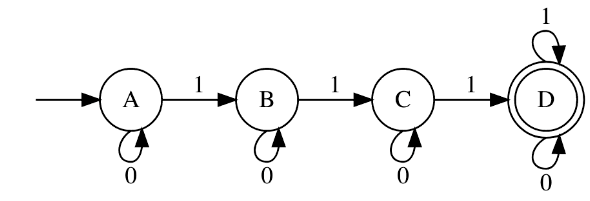

In [ ]:
# A list of the four states in our DFA, with the fourth state being represented by NIL.
STATES = makelist(1,1,1)

# Description: Implimentation of our DFA as a function in the enhanced lambda calculus. It takes two lists as input, 'l' and 's'.
# 'l' is the input to the DFA and 's' is the list of states for our DFA (we will always pass STATES as this second list).
# It returns 1 if the input is accepted by the DFA and 0 if not.
DFA = λ(m, l, s)(IF(ISEMPTY(l), IF(ISEMPTY(s), _1, _0), IF(HEAD(l), m(TAIL(l), TAIL(s)), m(TAIL(l), s))))

# Make the above function recursive
F = RECURSE(DFA)

# Use makelist to create the input to the DFA.
# Input: 101001
F(makelist(1,0,1,0,0,1),STATES)


1

In [ ]:
#Input: 111000
F(makelist(1,1,1,0,0,0),STATES)

1

In [ ]:
#Input: 10000
F(makelist(1,0,0,0,0),STATES)

0

In [ ]:
#Input: 10010
F(makelist(1,0,0,1,0),STATES)

0

In [ ]:
#Input: 1
F(makelist(1),STATES)

0

In [ ]:
#Input: 111
F(makelist(1,1,1),STATES)

1